# ChatGPT

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict, OrderedDict

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

import sys
sys.path.append("../")

from notebooklib.save import run_tsdr, save_tsdr, load_tsdr, load_tsdr_by_chaos

In [50]:
DATASET_ID = "9n6mf"
datasets = load_tsdr_by_chaos(
    DATASET_ID, suffix="fluxrank_pearsonr_medoid_only_ctnrs", revert_normalized_time_series=True,
)

In [88]:
from pathlib import Path
import string


PROMPTS_DIR = Path().resolve() / Path("dataset/prompts")

prompt = """あなたはマイクロサービスアプリケーションSock Shopを運用するSREです。
Sock Shopはcarts,catalogue,front-end,orders,user,payment,shippingの7個のマイクロサービスにより構成されています。
以下は、マイクロサービスを構成するコンテナ間のネットワーク通信の依存関係をmarmaid記法で表現したものです。

```mermaid
flowchart LR
front-end[front-end]
front-end --> orders[orders]
subgraph Orders
orders --> orders-db[orders-db]
end
front-end --> carts[carts]
subgraph Carts
carts --> carts-db[carts-db]
end
front-end --> user[user]
subgraph User
user[user] --> user-db[user-db]
end
front-end --> catalogue[catalogue]
subgraph Catalogue
cata --> catalogue-db[catalogue-db]
end
orders --> carts
orders --> user
orders --> payment[payment]
orders --> shipping[shipping]
```

以下のcsvは、front-endサービスのlatencyが増大し、システム障害が発生したときの、各マイクロサービスのlatency、throughput、errors、各マイクロサービス内の各コンテナのcpu使用量、memory使用量、filesystem(fs)のread/write数のメトリクスの時間変化を時系列データとして示しています。
表の行がメトリクス、列がプロットの順番（数値が増加するほど新しいデータ）を表しています。
上述のネットワーク依存関係を基に、これらの時系列データを解析し、どのメトリクスが原因であるかを調査してください。

${time_series}

"""

template_prompt = string.Template(prompt)

In [102]:
candidate_container_metrics = [
    "cpu_usage_seconds_total",
    "memory_working_set_bytes",
    "network_receive_bytes_total",
    "network_transmit_bytes_total",
    # "fs_reads_total",
    # "fs_writes_total",
    "fs_io_current",
]

container_metrics_regexp = "|".join([f".+_{m}$" for m in candidate_container_metrics])

In [103]:
record, data_df_by_metric_type = datasets[("pod-memory-hog", "user")][1]
dataset = pd.concat([
    data_df_by_metric_type["containers"][0].filter(regex=container_metrics_regexp),
    # record.data_df.filter(regex="^c-.+").filter(regex=container_metrics_regexp),
    record.data_df.filter(regex="^s-.+"),
    # data_df_by_metric_type["middlewares"][-1],
], axis=1)
print(record.chaos_case_full())

carts/pod-cpu-hog/4


In [104]:
csv_text: str = dataset[140:180].reset_index(drop=True).to_csv(sep=",", lineterminator="\n", index=True)
filled_prompt = template_prompt.safe_substitute(time_series=csv_text)
save_file_path = PROMPTS_DIR / "sockshop" / f"{record.chaos_case_full().replace('/', '-')}.txt"
save_file_path.parent.mkdir(parents=True, exist_ok=True)
save_file_path.write_text(filled_prompt)

14803

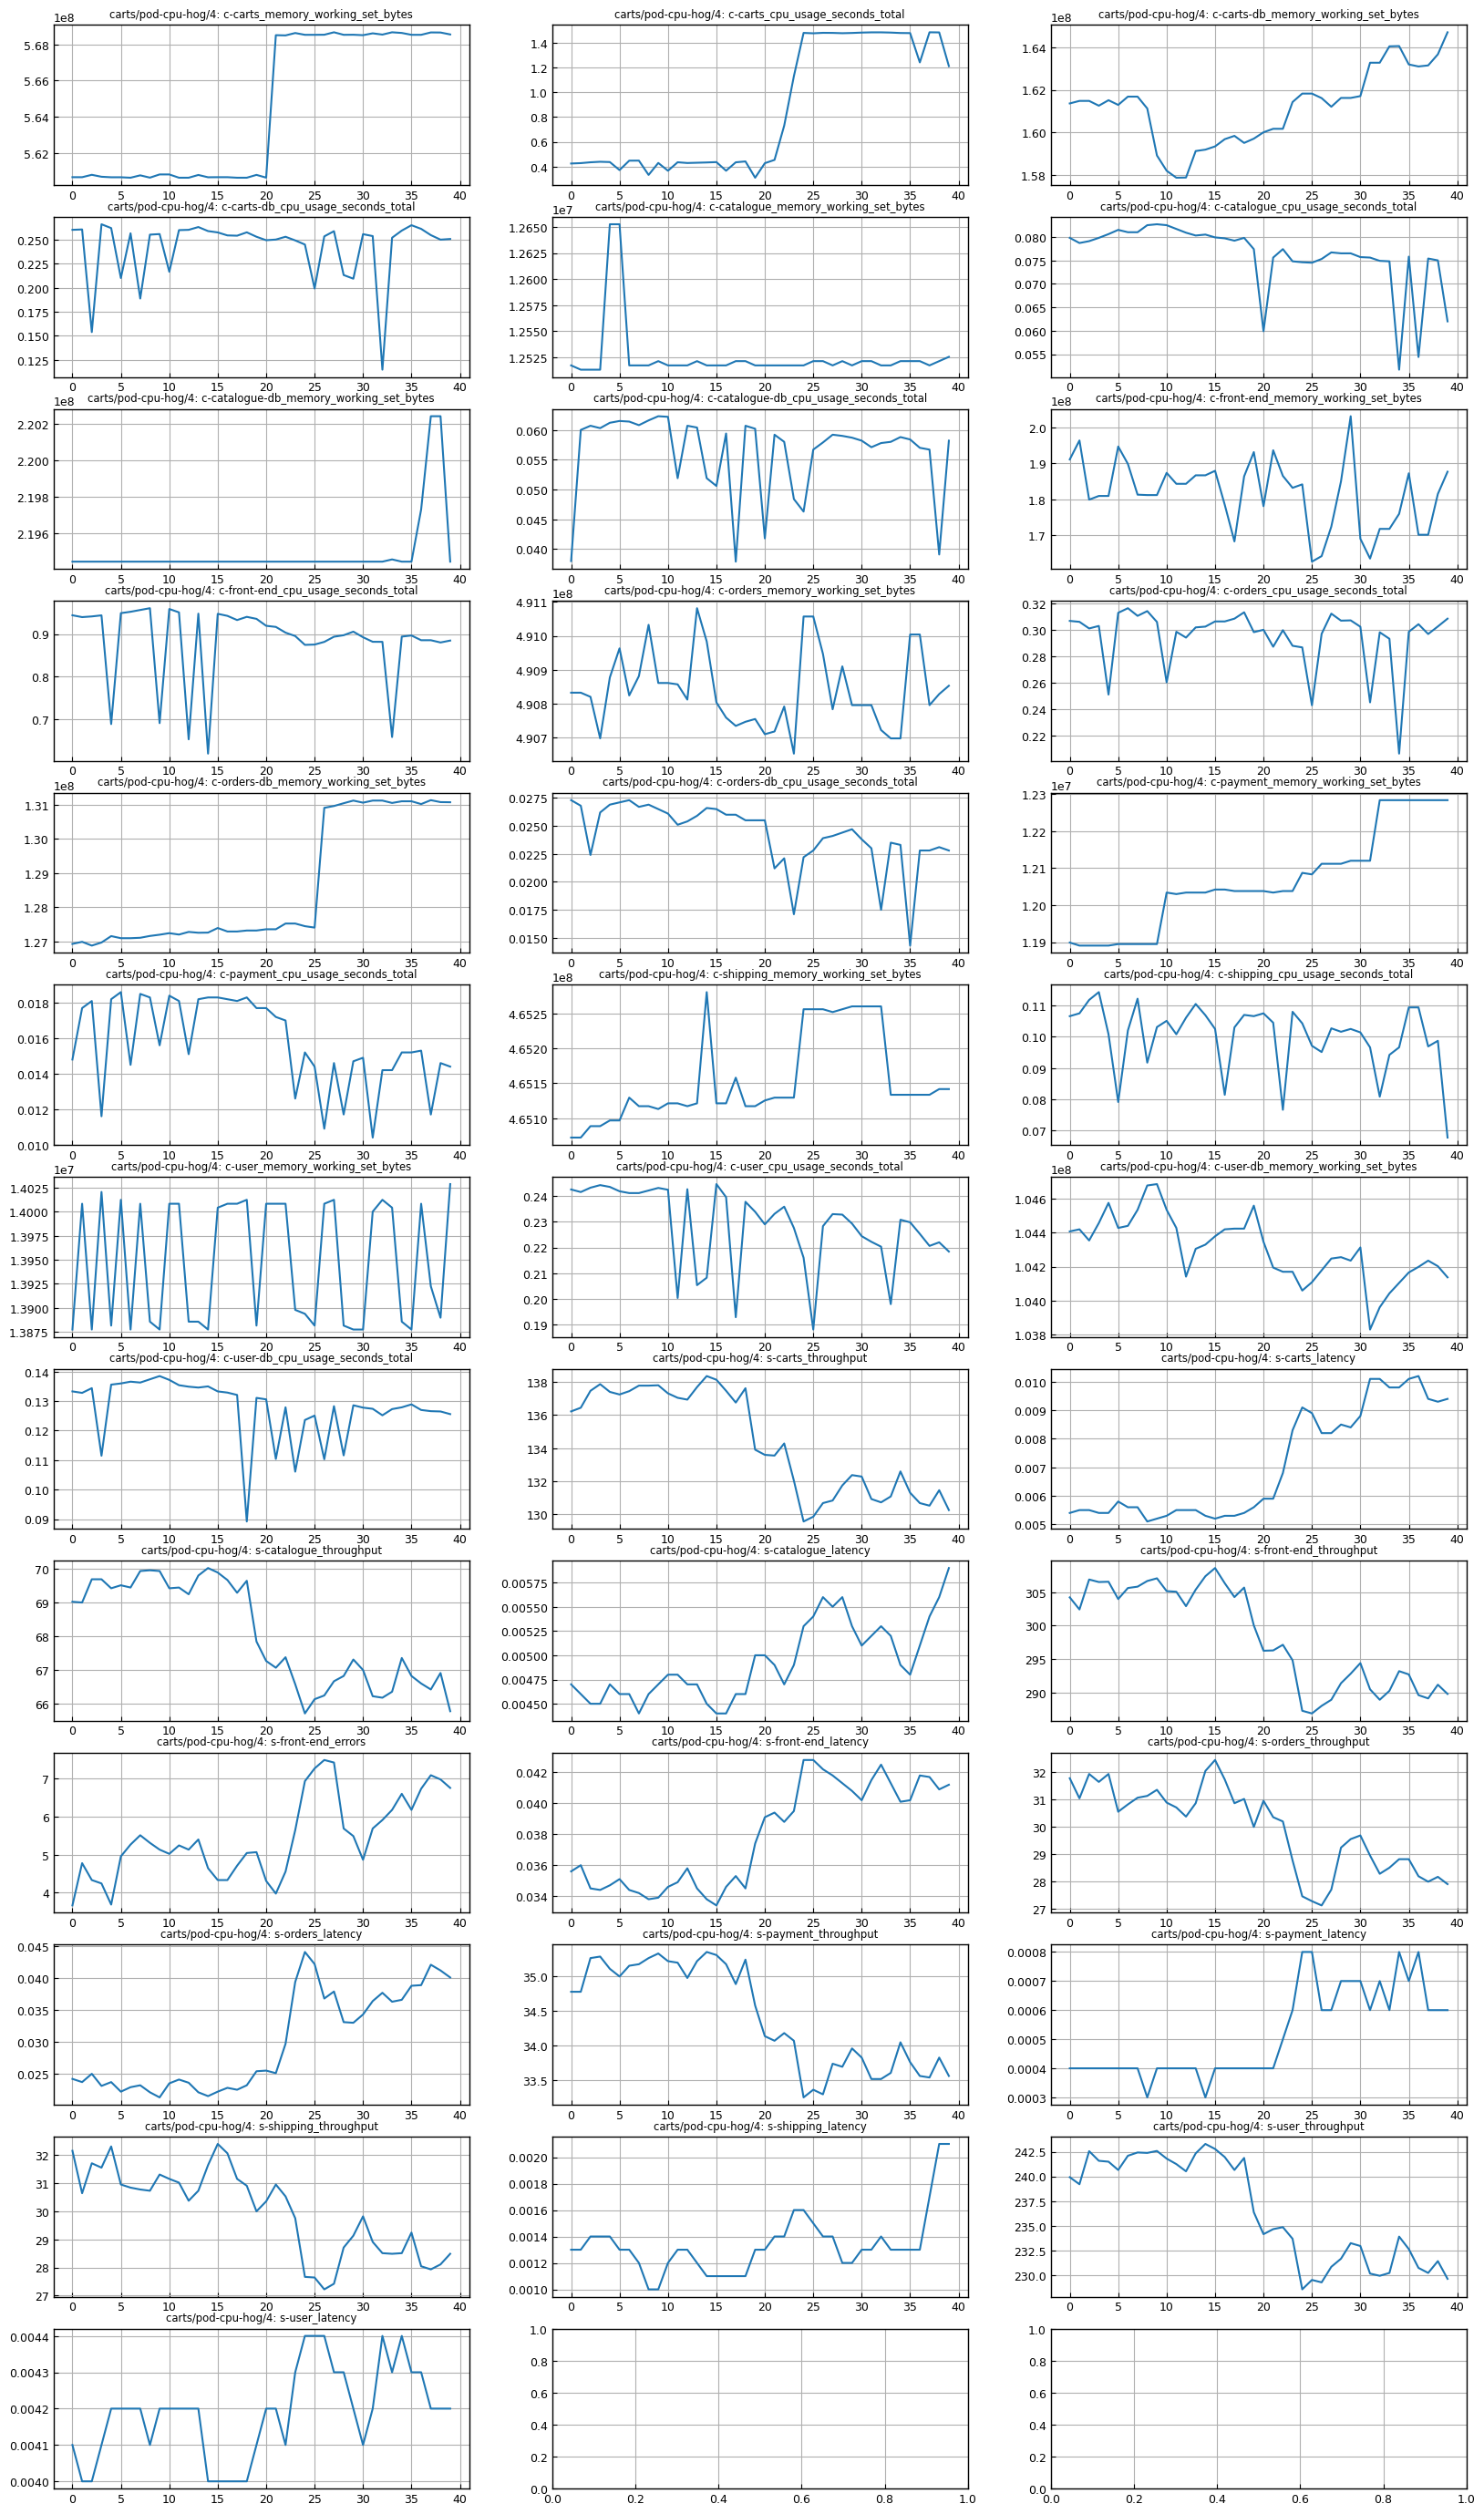

In [107]:
from notebooklib.plot import plot_dataset_dataframe

plot_dataset_dataframe(dataset[90:180].reset_index(drop=True), record)